### 1. **End-to-End Model with ResNet50**
Train the full ResNet50 architecture from scratch without pretrained weights on the cassava dataset.

**Data Loading & Preprocessing:**

In [ ]:
cassava = tfds.load('cassava', batch_size=32, as_supervised=True, with_info=True)
cassava

({'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
  'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
  'validation': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>},
 tfds.core.DatasetInfo(
     name='cassava',
     full_name='cassava/0.1.0',
     description="""
     Cassava consists of leaf images for the cassava plant depicting healthy and
     four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
     Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
     Dataset consists of a total of 9430 labelled images.
     The 9430 labelled images are split into a training set (5656), a test set(1885)
     

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the cassava dataset with predefined splits
ds = tfds.load('cassava', split=['train', 'validation', 'test'], as_supervised=True, download=True)
train_ds, val_ds, test_ds = ds[0], ds[1], ds[2]

# Preprocess the dataset
def preprocess(image, label):
    image = tf.image.resize(image, (180, 180))  # Resize to the expected input size for ResNet50
    image = preprocess_input(image)  # Apply ResNet50 preprocessing
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# Batch the datasets
train_ds = train_ds.batch(8).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# Check the shape of the inputs and targets
for inputs, targets in train_ds.take(1):
    print("Input shape:", inputs.shape)  # Should be (8, 180, 180, 3)
    print("Target shape:", targets.shape)  # Should be (8,)


Input shape: (8, 180, 180, 3)
Target shape: (8,)


 **Model Definition:**


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Initialize the ResNet50 model
resnet_model = ResNet50(include_top=True,
                        weights=None,
                        input_shape=(180, 180, 3),
                        classes=5)

**Compile the Model:**

In [14]:

resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Callbacks and Training:**


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint('resnet50_best.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[checkpoint, early_stopping])

Epoch 1/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 2999s 4s/step - accuracy: 0.4309 - loss: 2.0301 - val_accuracy: 0.4929 - val_loss: 1.3337
Epoch 2/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 2911s 4s/step - accuracy: 0.5672 - loss: 1.2113 - val_accuracy: 0.5453 - val_loss: 1.2653
Epoch 3/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 3031s 4s/step - accuracy: 0.5901 - loss: 1.1604 - val_accuracy: 0.5511 - val_loss: 1.2171


  **Plot Results:**
  

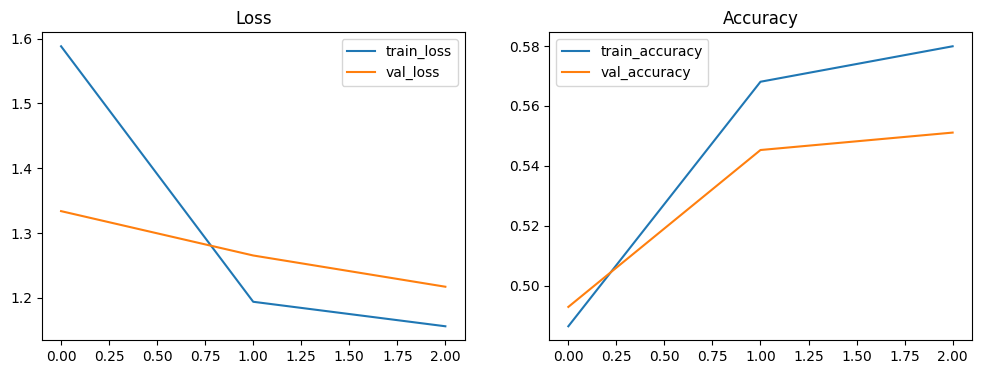

In [16]:

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

- **Comment on Results:**

The model did not perform very well and it took about 40 mins for each iteration. It also seems to be ovefitting but it is difficult to tell since I have not used enough iterations and the loss seems to be improving.

### 2. **Feature Extraction**
  Use ResNet50 as a feature extractor with pretrained weights and add dense layers for classification.

  **Base Model:**

In [18]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(180, 180, 3))
base_model.trainable = False  # Freeze base model

# Add custom top layers
model = models.Sequential([
base_model,
layers.GlobalAveragePooling2D(),
layers.Dense(256, activation='relu'),
layers.Dropout(0.5),
layers.Dense(5, activation='softmax')
        ])

# Compile and Train
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[checkpoint, early_stopping])


Epoch 1/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 884s 1s/step - accuracy: 0.5743 - loss: 1.2855 - val_accuracy: 0.7057 - val_loss: 0.8112
Epoch 2/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 831s 1s/step - accuracy: 0.6732 - loss: 0.8801 - val_accuracy: 0.7088 - val_loss: 0.7757
Epoch 3/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 865s 1s/step - accuracy: 0.6994 - loss: 0.8142 - val_accuracy: 0.7358 - val_loss: 0.7251


**Evaluate and Comment:**

These results seem to be way better and there was significant improvement. The loss and the accuracy improved greatly and the iterations were much faster each took only about 10mins. I would have also liked to choose different optimizers, however, due to the time constraint this was not possible for this assignment.

### 3. **"Xception-like" Model**
  Implement a model similar to Xception and experiment with data augmentation.
  
**Data Augmentation:**

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

 **Training and Evaluation:** Use early stopping and evaluate the impact of data augmentation.

### 4. **Comparison with Xception Model**
   Analyze the similarities between the "Xception-like" model and the Keras Xception model.

 **Load and Explore Xception:**

In [20]:
from tensorflow.keras.applications import Xception
model = Xception(weights=None, input_shape=(180, 180, 3), classes=5)
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 89, 89, 32)     │            864 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 89, 89, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 89, 89, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 87, 87, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 87, 87, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 87, 87, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 87, 87, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 87, 87, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 87, 87, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 87, 87, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 87, 87, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 44, 44, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 44, 44, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

Depthwise convolution is done by, for example, convoluting with 3 kernels with shape 3x3x1. Each kernel iterates on only one channel of the image-producing an intermediate output of shape 5x5x1 which is stacked together to create an output of shape 5x5x3.


### 5. **Fine-Tuning Pre-trained Weights (Extra)**
   

In [21]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=[checkpoint, early_stopping])

Epoch 1/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 3118s 4s/step - accuracy: 0.5214 - loss: 1.2947 - val_accuracy: 0.4717 - val_loss: 1.3062
Epoch 2/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 3164s 4s/step - accuracy: 0.6093 - loss: 1.0276 - val_accuracy: 0.6183 - val_loss: 1.0566
Epoch 3/3
707/707 ━━━━━━━━━━━━━━━━━━━━ 3116s 4s/step - accuracy: 0.7063 - loss: 0.7871 - val_accuracy: 0.6098 - val_loss: 1.1940


I have also seen improvement of my results in terms of training loss and accuracy with the fine tuning of the pre-trained weights. However, it did not improve the same metrics for validation so it is possibly overfitting.